# KNN Modelo


In [6]:
import pandas as pd
import preprocessing as pp
import formatPredictions as fp
import metrics as m
import datasets as datasets

# Importacion KNN
from sklearn.neighbors import KNeighborsClassifier

# Importacion preprocesamiento
from sklearn.model_selection import train_test_split

In [7]:
# Divido el set en entrenamiento y validacion
dfTrain = datasets.getDataTrain()
dfTrain_feature_engineering = pp.feature_engineering_KNN_SVM_Naive_Bayes(dfTrain)
X = dfTrain_feature_engineering.drop(columns = 'tiene_alto_valor_adquisitivo')
y = dfTrain_feature_engineering.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [8]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Metricas

Accuracy: 0.8151389528635038

Precision: 0.6343390804597702

Recall: 0.8968591691995947

F1 Score: 0.5946127946127946

Matriz de confusion: 
[[4426  509]
 [ 695  883]]

AUC-ROC: 



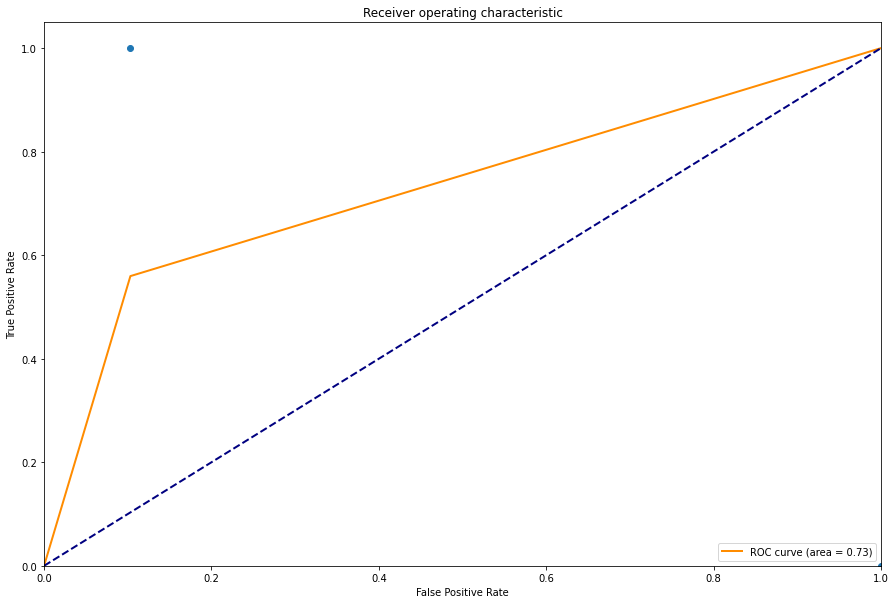

0.7282141219888975

In [9]:
m.metrics(y_test, y_pred)

# Prediccion

In [10]:
# Obtengo el set para predecir
dfObjetivo = datasets.getDataValidation()

# Elimino columnas "representatividad_poblacional" y "id"
dfObjetivo.drop(columns = ['representatividad_poblacional', 'id'], inplace = True)

# Aplico feature engineering
dfObjetivo_feature_engineering = pp.feature_engineering_KNN_SVM_Naive_Bayes(dfObjetivo)

predicciones = knn.predict(dfObjetivo_feature_engineering)
predicciones

array([0, 0, 0, ..., 1, 1, 1])

In [11]:
fp.exportPredictions(fp.formatPredictions(predicciones), "pd_predictions_final_knn")